<a class="anchor" id="0.1"></a>
## Table of Contents

1. [Acknowledgements](#1)
1. [Import libraries](#2)
1. [Download data](#3)
1. [EDA](#4)
1. [Data Cleaning](#5)
1. [WordCloud](#6)
1. [Bag of Words Counts](#7)
1. [TF IDF](#8)
1. [GloVe](#9)
1. [Showing Confusion Matrix for GloVe](#10)

## 2. Import libraries <a class="anchor" id="2"></a>

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

## 3. Download data <a class="anchor" id="3"></a>

In [2]:
data = pd.read_csv('../input/nlp-reports-news-classification/water_problem_nlp_en_for_Kaggle_100.csv', delimiter=';', header=0)
data = data.fillna(0)

convert_dict = {'text': str, 
                'env_problems': int,
                'pollution': int, 
                'treatment': int,
                'climate': int,
                'biomonitoring': int} 
  
data = data.astype(convert_dict)
data

,text,env_problems,pollution,treatment,climate,biomonitoring
0,In the Southern Bug basin wastewater is discha...,1,1,0,0,0
1,This amount is distributed as follows: urban a...,1,1,0,0,0
2,Despite the similar volumes of discharged wast...,1,1,0,0,0
3,They bring 84% of organic pollution 86% of pho...,1,1,0,0,0
4,The input of the industry is between 7–21% and...,1,1,0,0,0
...,...,...,...,...,...,...
95,Chemical composition of water bodies shall com...,0,0,0,0,0
96,According to the Directive provisions water bo...,0,0,0,0,0
97,Besides in the field of data processing during...,0,0,0,0,0
98,Use of these values was offered by the Monitor...,0,0,0,0,0


In [3]:
# Take "env_problems" only
target_name = 'env_problems'
name_for_plot = 'environmental problems'
data = data[['text', target_name]]
data.columns = ['text', 'target']
data

,text,target
0,In the Southern Bug basin wastewater is discha...,1
1,This amount is distributed as follows: urban a...,1
2,Despite the similar volumes of discharged wast...,1
3,They bring 84% of organic pollution 86% of pho...,1
4,The input of the industry is between 7–21% and...,1
...,...,...
95,Chemical composition of water bodies shall com...,0
96,According to the Directive provisions water bo...,0
97,Besides in the field of data processing during...,0
98,Use of these values was offered by the Monitor...,0


In [4]:
# The TASK for this dataset requires that the test set contain at least 40% of the data 
train, test = train_test_split(data, test_size=0.4, shuffle=True, random_state=0)
train_base = train.copy()
train_target = train_base['target']
test_base = test.copy()
test_target = test_base['target']

In [5]:
print('There are {} rows and {} columns in train'.format(data.shape[0],data.shape[1]))
print('There are {} rows and {} columns in train'.format(test.shape[0],test.shape[1]))

There are 100 rows and 2 columns in train
There are 40 rows and 2 columns in train


In [6]:
data.head(10)

,text,target
0,In the Southern Bug basin wastewater is discha...,1
1,This amount is distributed as follows: urban a...,1
2,Despite the similar volumes of discharged wast...,1
3,They bring 84% of organic pollution 86% of pho...,1
4,The input of the industry is between 7–21% and...,1
5,Settlements that do not have sewage systems us...,1
6,Equipment of WWTPs is very worn-out the amount...,1
7,The current state of sewage networks is a sour...,1
8,Consequently in Ukraine on average 2 accidents...,1
9,The load of pollutants from accidental dischar...,0


## 4. EDA <a class="anchor" id="4"></a>

### Class distribution

Before we begin with anything else, let's check the class distribution.

In [7]:
# extracting the number of examples of each class
Real_len = data[data['target'] == 1].shape[0]
Not_len = data[data['target'] == 0].shape[0]

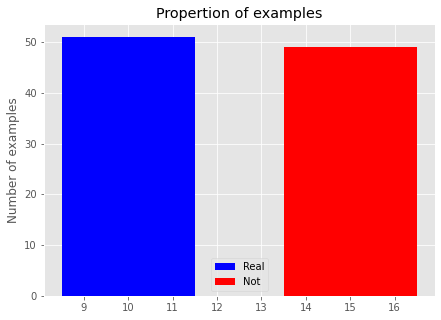

In [8]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

### Number of characters in datas

In [9]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [10]:
data['length'] = data['text'].apply(length)

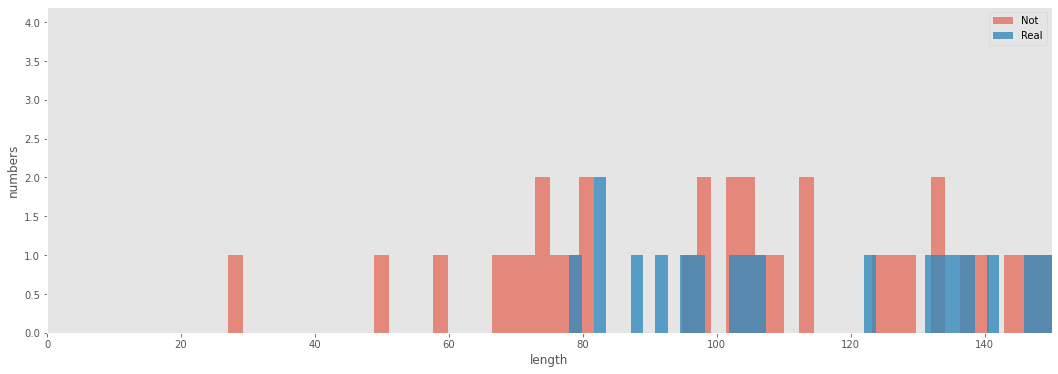

In [11]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(data[data['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(data[data['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

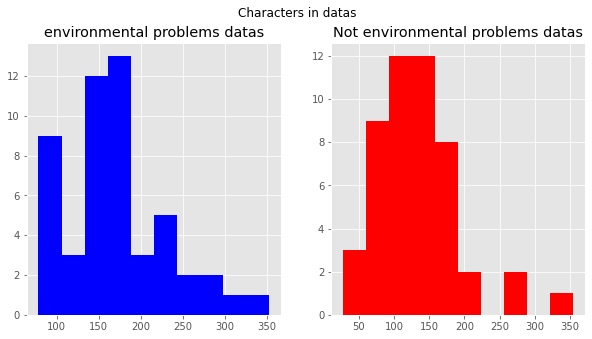

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len=data[data['target']==1]['text'].str.len()
ax1.hist(data_len,color='blue')
ax1.set_title(f'{name_for_plot} datas')
data_len=data[data['target']==0]['text'].str.len()
ax2.hist(data_len,color='red')
ax2.set_title(f'Not {name_for_plot} datas')
fig.suptitle('Characters in datas')
plt.show()

The distributions are different. 150 characters in a data are the one of the most common among both.

### Number of words in a data

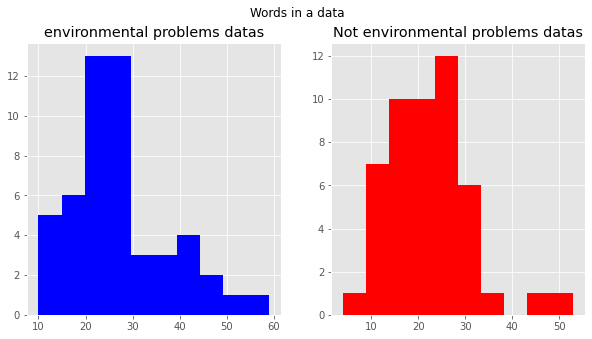

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(data_len,color='blue')
ax1.set_title(f'{name_for_plot} datas')
data_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(data_len,color='red')
ax2.set_title(f'Not {name_for_plot} datas')
fig.suptitle('Words in a data')
plt.show()


###  Average word length in a data

Text(0.5, 0.98, 'Average word length in each data')

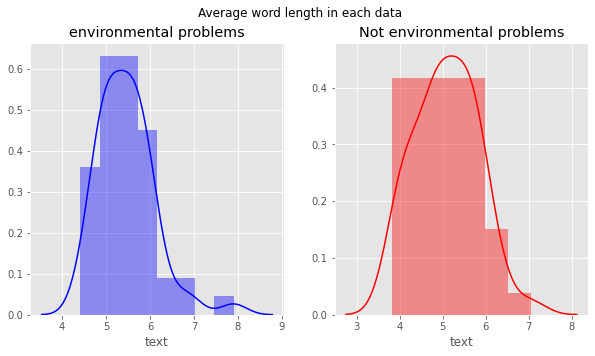

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=data[data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title(name_for_plot)
word=data[data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title(f'Not {name_for_plot}')
fig.suptitle('Average word length in each data')

In [15]:
def create_corpus(target):
    corpus=[]
    
    for x in data[data['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [16]:
def create_corpus_df(data, target):
    corpus=[]
    
    for x in data[data['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Common stopwords in datas

First we  will analyze datas with class 0.

In [17]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [18]:
# displaying the stopwords
np.array(stop)

array({'isn', 'won', 'down', 'its', 'be', 'under', 'again', 'mightn', 'can', 'over', 'aren', 'do', 'we', 'you', "that'll", 'the', 'from', 'until', 'yours', 'such', 'itself', 'here', 'o', "shouldn't", 'all', "mightn't", 'on', 'yourselves', 'if', 'them', 'so', 'or', 'of', 'no', 'wasn', 'herself', 'off', 'some', 'about', 'now', 'll', 's', 'have', 'during', 'hasn', "shan't", "haven't", 'any', 'these', 'into', 'doesn', 'does', 'doing', 've', 'how', 'did', "you're", 'ain', 'he', 'myself', "hadn't", 't', 'should', 'when', 'both', 'those', 'up', 'she', 'are', "you'd", "didn't", 'haven', 'nor', 'own', 'ours', 'same', 'a', "weren't", 'our', 'am', 'couldn', 'your', 'has', 'this', "you'll", 'below', 'mustn', 're', 'with', 'their', "won't", "couldn't", 'too', 'wouldn', 'themselves', 'once', 'why', 'hadn', 'there', 'but', 'further', 'having', 'me', 'most', 'his', "don't", 'in', 'by', 'y', "hasn't", "needn't", "you've", 'weren', 'between', "it's", 'had', 'ourselves', 'while', 'after', 'very', 'what',

<BarContainer object of 10 artists>

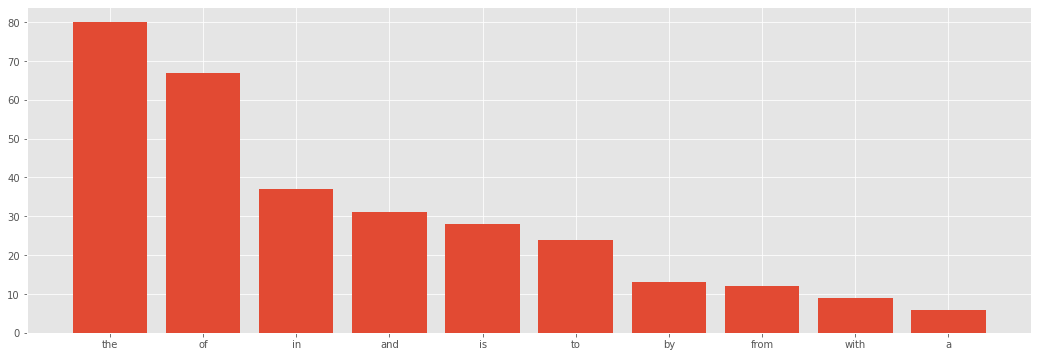

In [19]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

Now,we will analyze datas with class 1.

<BarContainer object of 10 artists>

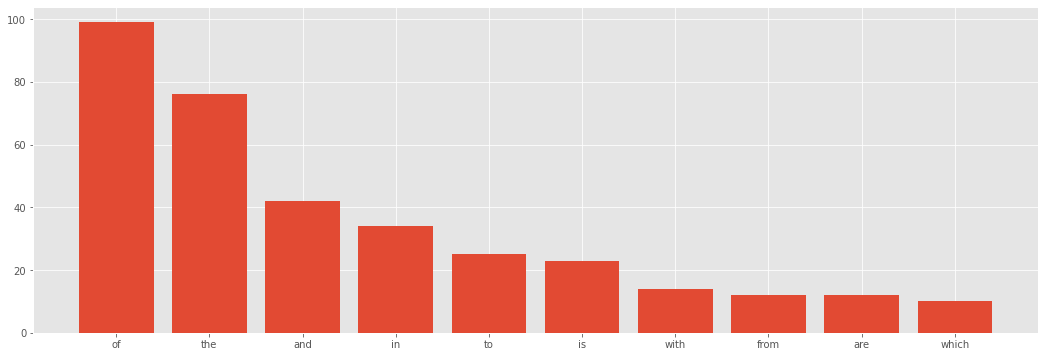

In [20]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

In both of them,"of" and "the" dominates which are followed by "in" in class 0 and "and" in class 1.

### Analyzing punctuations

First let's check datas indicating clas 1.

<BarContainer object of 5 artists>

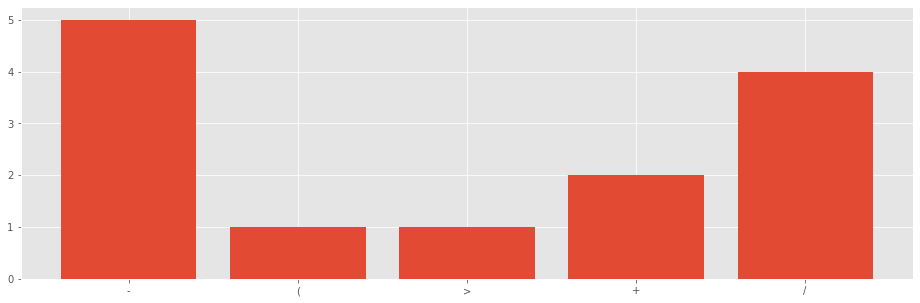

In [21]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

Now,we will move on to class 0.

<BarContainer object of 1 artists>

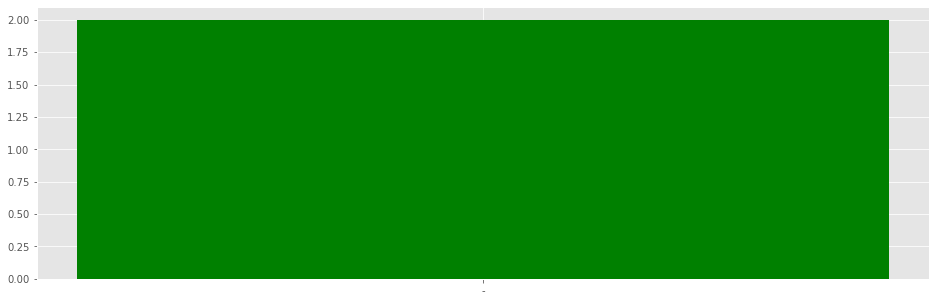

In [22]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

### Common words

In [23]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

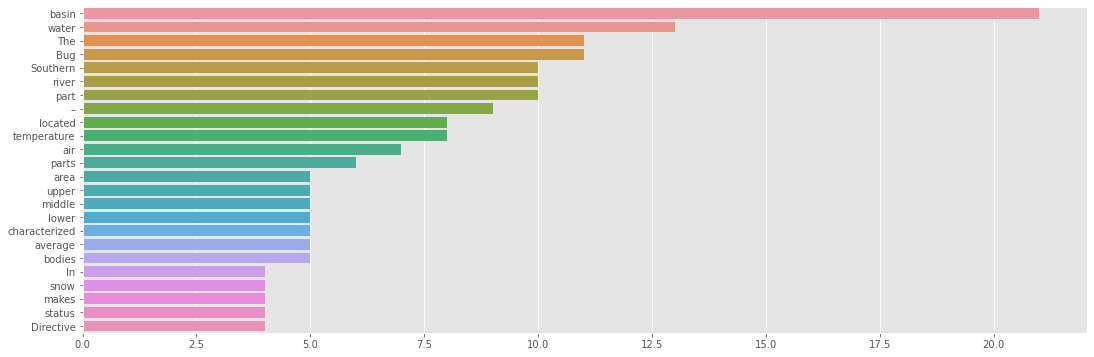

In [24]:
sns.barplot(x=y,y=x)

Lot of cleaning needed !

### N-gram analysis

we will do a bigram (n=2) analysis over the datas. Let's check the most common bigrams in datas.

In [25]:
def get_top_data_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

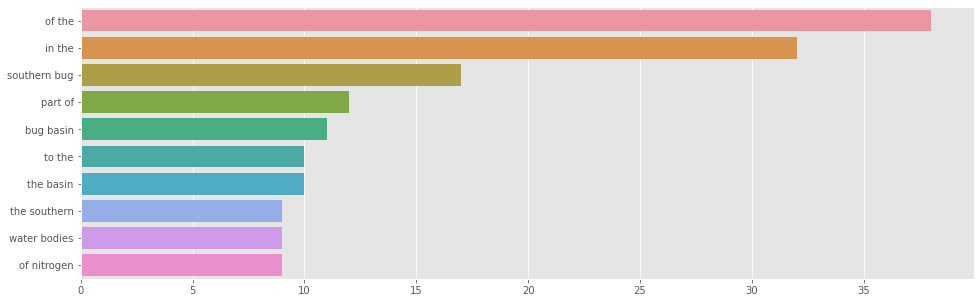

In [26]:
plt.figure(figsize=(16,5))
top_data_bigrams=get_top_data_bigrams(data['text'])[:10]
x,y=map(list,zip(*top_data_bigrams))
sns.barplot(x=y,y=x)

## 5. Data Cleaning <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

In [27]:
df = pd.concat([train,test])
df.shape

(100, 2)

### Removing urls

In [28]:
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

In [29]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [30]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

### Removing HTML tags

In [31]:
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [32]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [33]:
df['text']=df['text'].apply(lambda x : remove_html(x))

### Removing Emojis

In [34]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [35]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

### Removing punctuations

In [36]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [37]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

### Big target correction

In [38]:
target_big_corrected = True

In [39]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def clean_datas(data):
    """Removes links and non-ASCII characters"""
    
    data = ''.join([x for x in data if x in string.printable])
    
    # Removing URLs
    data = re.sub(r"http\S+", "", data)
    
    return data

In [40]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [41]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [42]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life redata", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "redata",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "data me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [43]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [44]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [45]:
def data_clearning(df):
    # Data clearning
    df["text"] = df["text"].apply(lambda x: clean_datas(x))
    df["text"] = df["text"].apply(lambda x: remove_emoji(x))
    df["text"] = df["text"].apply(lambda x: remove_punctuations(x))
    df["text"] = df["text"].apply(lambda x: convert_abbrev_in_text(x))
    return df

In [46]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
if target_big_corrected:
    train = data_clearning(train)
    test = data_clearning(test)
    data = data_clearning(data)

## 6. WordCloud <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

### Target = 1

In [47]:
corpus_new1=create_corpus_df(df,1)
len(corpus_new1)

1365

In [48]:
corpus_new1[:10]

['This',
 'amount',
 'is',
 'distributed',
 'as',
 'follows',
 'urban',
 'and',
 'rural',
 'housing']

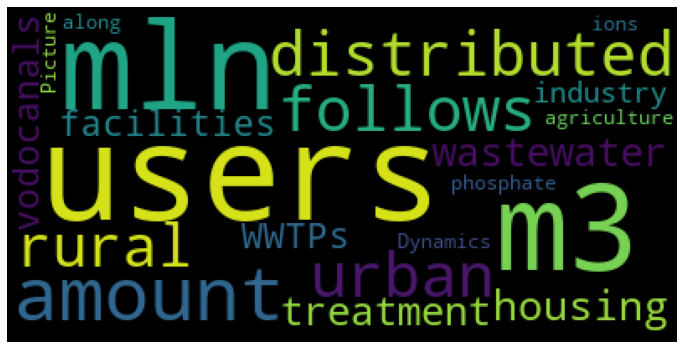

In [49]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Target = 0

In [50]:
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)

1072

In [51]:
corpus_new0[:10]

['The',
 'basin',
 'includes',
 '189',
 'water',
 'storage',
 'reservoirs',
 'and',
 '9640',
 'lakes']

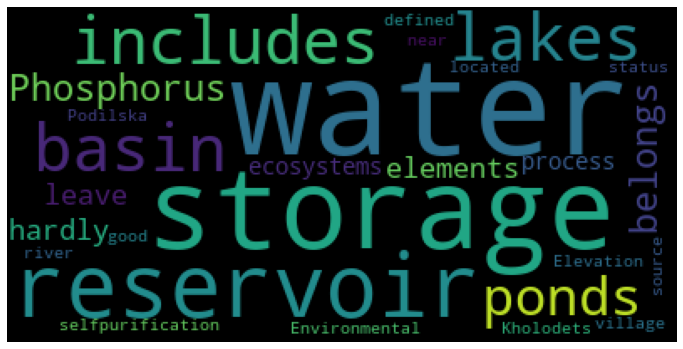

In [52]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [53]:
df.head(10)

,text,target
1,This amount is distributed as follows urban an...,1
61,The basin includes 189 water storage reservoir...,0
42,Dynamics of phosphate ions along the length of...,1
41,Phosphorus belongs to the elements which hardl...,0
4,The input of the industry is between 7–21 and ...,1
15,This method allows extracting only a part of p...,1
17,The existing wastewater treatment facilities w...,1
40,It is worth of mentioning the low level of tre...,1
38,This leads to balance destruction between soli...,1
5,Settlements that do not have sewage systems us...,1


## 7. Bag of Words Counts <a class="anchor" id="7"></a>

[Back to Table of Contents](#0.1)

Thanks to https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

In [54]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [55]:
# Preparation data for processing
X_train = train["text"].tolist()
y_train = train["target"].tolist()
X_train_counts, count_vectorizer = cv(X_train)

X_test = test["text"].tolist()
y_test = test["target"].tolist()
X_test_counts = count_vectorizer.transform(X_test)

### Visualizing the embeddings

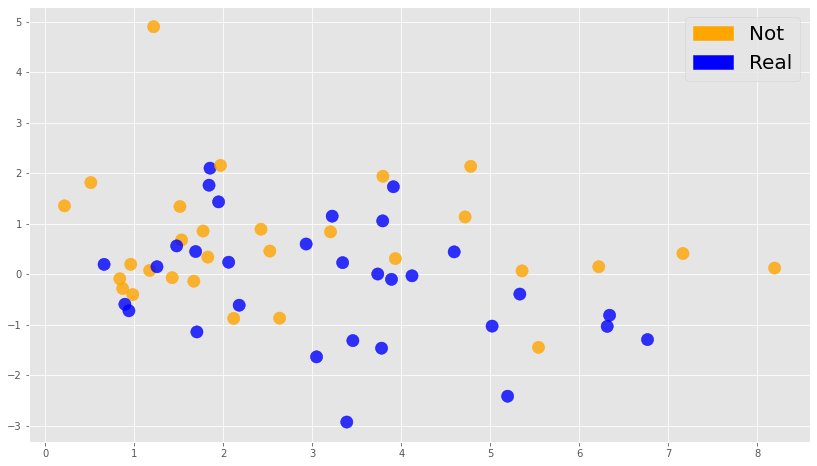

In [56]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=150, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

fig = plt.figure(figsize=(14, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

## 8. TF IDF <a class="anchor" id="8"></a>

[Back to Table of Contents](#0.1)

In [57]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

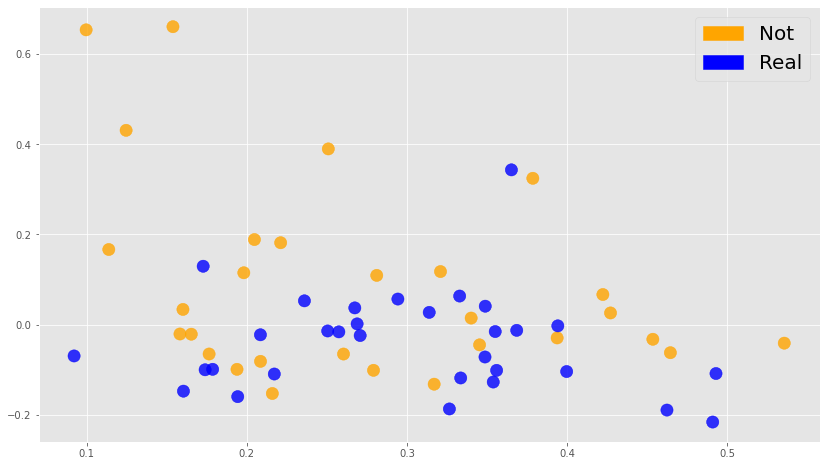

In [58]:
fig = plt.figure(figsize=(14, 8))
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings are not badly separated.

## 9. GloVe <a class="anchor" id="9"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

Here we will use GloVe pretrained corpus model to represent our words. It is available in 3 varieties : 50D, 100D and 200 Dimentional. We will try 100D here.

In [59]:
def create_corpus_new(df):
    corpus=[]
    for data in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(data)]
        corpus.append(words)
    return corpus   

In [60]:
corpus=create_corpus_new(df)

100%|██████████| 100/100 [00:00<00:00, 2052.88it/s]


In [61]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [62]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

data_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [63]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 815


In [64]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec           

100%|██████████| 815/815 [00:00<00:00, 263274.63it/s]


In [65]:
data_pad[0][0:]

array([ 44,  51,   6, 311,  36, 312, 132,   4, 185, 186,  16,  29,  37,
        45, 133,  19, 313,  68,  69, 314,  52, 187,  19, 315,  68,  69,
       188,  52, 189,  19, 316,  68,  69, 317,  52, 134,  52,  19,  70,
        68,  69, 190,  52,  91, 318,   0,   0,   0,   0,   0], dtype=int32)

## Baseline Model with GloVe results

In [66]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=4e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           81600     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 162,101
Trainable params: 80,501
Non-trainable params: 81,600
_________________________________________________________________


In [68]:
data_pad.shape

(100, 50)

In [69]:
train=data_pad[:train.shape[0]]
test=data_pad[train.shape[0]:]

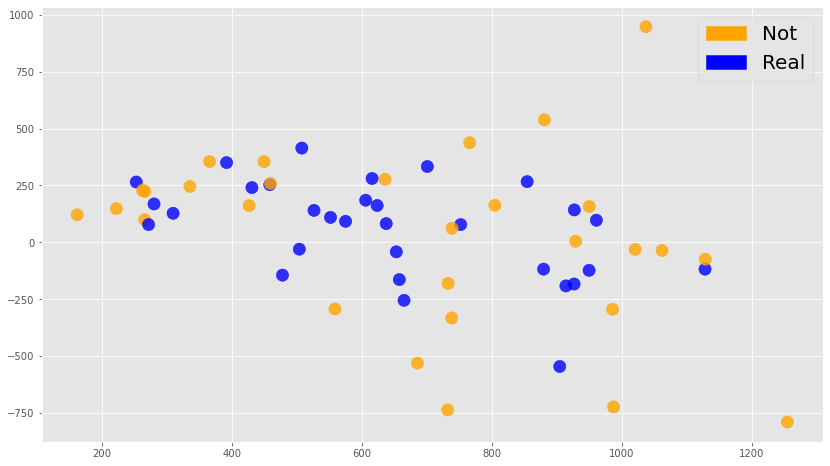

In [70]:
# Training data
fig = plt.figure(figsize=(14, 8))          
plot_LSA(train,train_target)
plt.show()

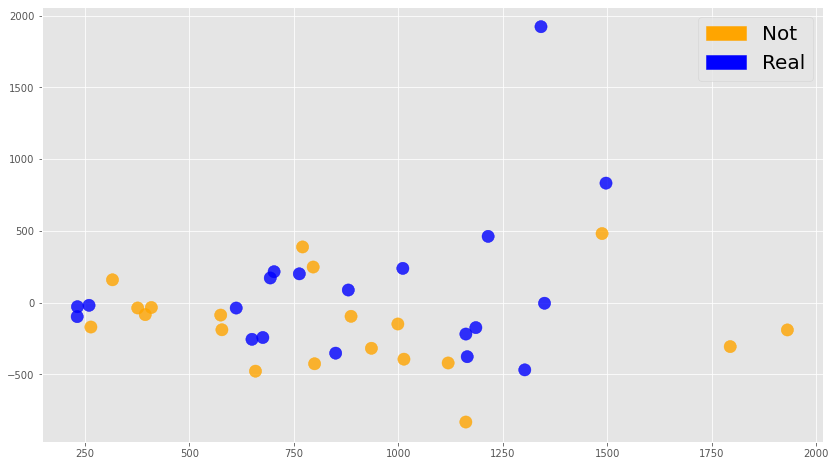

In [71]:
# Test data
fig = plt.figure(figsize=(14, 8))          
plot_LSA(test,test_target)
plt.show()

In [72]:
# Model tuning
history=model.fit(train,train_target,batch_size=12,epochs=20,validation_data=(test,test_target),verbose=2)

Epoch 1/20
5/5 - 1s - loss: 0.6963 - accuracy: 0.4833 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/20
5/5 - 0s - loss: 0.6871 - accuracy: 0.5167 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 3/20
5/5 - 0s - loss: 0.6811 - accuracy: 0.5167 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 4/20
5/5 - 0s - loss: 0.6791 - accuracy: 0.5167 - val_loss: 0.6864 - val_accuracy: 0.5000
Epoch 5/20
5/5 - 0s - loss: 0.6748 - accuracy: 0.5167 - val_loss: 0.6848 - val_accuracy: 0.5000
Epoch 6/20
5/5 - 0s - loss: 0.6709 - accuracy: 0.5167 - val_loss: 0.6829 - val_accuracy: 0.5000
Epoch 7/20
5/5 - 0s - loss: 0.6700 - accuracy: 0.5333 - val_loss: 0.6807 - val_accuracy: 0.5250
Epoch 8/20
5/5 - 0s - loss: 0.6632 - accuracy: 0.5167 - val_loss: 0.6786 - val_accuracy: 0.5500
Epoch 9/20
5/5 - 0s - loss: 0.6573 - accuracy: 0.5667 - val_loss: 0.6764 - val_accuracy: 0.5750
Epoch 10/20
5/5 - 0s - loss: 0.6589 - accuracy: 0.5833 - val_loss: 0.6733 - val_accuracy: 0.5750
Epoch 11/20
5/5 - 0s - loss: 0.6507 - a

In [73]:
train_pred_GloVe = model.predict(train)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

## 10. Showing Confusion Matrix for GloVe <a class="anchor" id="10"></a>

[Back to Table of Contents](#0.1)

In [74]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

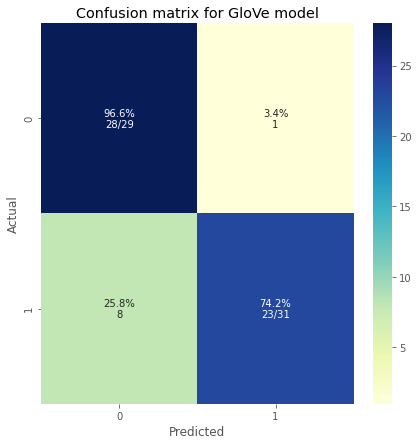

In [75]:
# Showing Confusion Matrix for GloVe model
plot_cm(y_train, train_pred_GloVe_int, 'Confusion matrix for GloVe model', figsize=(7,7))

In [76]:
# Test prediction
test_pred = model.predict(test).round().astype('int')
print('Accuracy score of the test prediction by the GloVe model -', accuracy_score(test_target, test_pred))

Accuracy score of the test prediction by the GloVe model - 0.8


[Go to Top](#0)